In [1]:
# Cell 1/11 — Install & Imports
!nvidia-smi
!pip install --quiet obspy xgboost joblib gdown tqdm seaborn matplotlib pandas numpy scikit-learn
!pip install streamlit obspy xgboost joblib folium matplotlib seaborn pandas numpy scikit-learn


import os, random, datetime, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, HTML

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost as xgb
import joblib
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta, trigger_onset

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

print("✅ Imports complete. Ready to run the pipeline.")


Sat Nov 15 14:02:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cell 2/11 — Seed + constants
import torch

def set_seed(seed=4):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    os.environ['PYTHONHASHSEED'] = str(seed)
    try:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass

set_seed(4)
print("✅ Seed set to 4 for reproducibility.")

# Paths & constants
FILE_ID = "1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2"   # dataset file id (same as your original)
DATA_FILENAME = "EEW_features_2024-10-21.csv"
GDRIVE_URL = f"https://drive.google.com/uc?id={FILE_ID}"
MODEL_OUT = "/content/xgb_eew_final.joblib"
PREPROC_OUT = "/content/preproc_objects.joblib"

p_wave_features = [
    'pkev12','pkev23','durP','tauPd','tauPt',
    'PDd','PVd','PAd','PDt','PVt','PAt',
    'ddt_PDd','ddt_PVd','ddt_PAd','ddt_PDt','ddt_PVt','ddt_PAt'
]

print("✅ Constants defined. P-wave feature list length:", len(p_wave_features))


✅ Seed set to 4 for reproducibility.
✅ Constants defined. P-wave feature list length: 17


In [3]:
# Cell 3/11 — Download dataset and initial cleaning
import gdown
print("Downloading dataset...")
gdown.download(GDRIVE_URL, DATA_FILENAME, quiet=False)

# Attempt to read with skiprows=[1] (keeps your original)
try:
    df = pd.read_csv(DATA_FILENAME, skiprows=[1])
except Exception:
    df = pd.read_csv(DATA_FILENAME)

# Strip column names and coerce numeric where applicable
df.columns = df.columns.str.strip()
for col in df.columns:
    if col not in ['filename', 'date', 'time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill numeric NaNs with median
df = df.fillna(df.median(numeric_only=True))

# Keep only rows where all required p-wave features are > 0
df_before = len(df)
df = df[(df[p_wave_features] > 0).all(axis=1)]
df_after = len(df)

print(f"Dataset loaded. Rows before filter: {df_before}, after filter: {df_after}")
display(df.head(3))


Downloading...
From: https://drive.google.com/uc?id=1a8XaGByqoz9xmpsFylUf7HXXAfOx8Aj2
To: /content/EEW_features_2024-10-21.csv
100%|██████████| 6.82M/6.82M [00:00<00:00, 64.0MB/s]


Dataset loaded. Rows before filter: 25436, after filter: 21687


,filename,date,time,Rmag,Rdpth,Rlat,Rlon,Station,Sheight,Slat,...,ddt_PDd,ddt_PVd,ddt_PAd,ddt_PDt,ddt_PVt,ddt_PAt,PGA,PGV,tPGA,tPGV
0,'HKD0540001282321.EW',2000/01/28,23:21:00,6.8,56,42.983,146.711,NaN,63.0,43.7996,...,0.00637,0.08890,0.69803,0.04389,0.21261,1.91145,26.949,7.176,32.19,31.36
1,'HKD0550001282321.EW',2000/01/28,23:21:00,6.8,56,42.983,146.711,NaN,23.0,43.8244,...,0.00554,0.05553,1.18973,0.05951,0.39105,6.53578,60.838,8.211,30.04,30.43
2,'HKD0590001282321.EW',2000/01/28,23:21:00,6.8,56,42.983,146.711,NaN,30.0,43.8569,...,0.02187,0.09294,1.50502,0.07332,0.26394,7.50573,108.173,17.529,28.40,31.00


Splits created:
  Train: 17349 Validation: 2169 Test: 2169


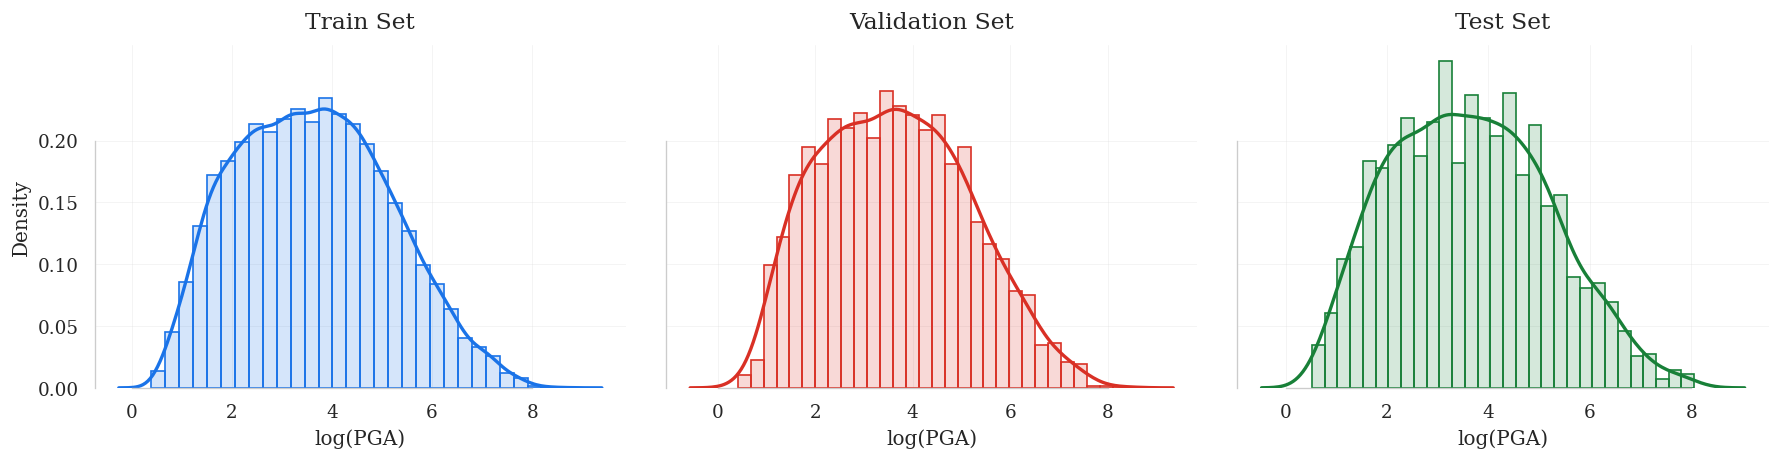

In [4]:
# Cell 4/11 — Prepare X, y and stratified splits (same as your original)
X = df[p_wave_features].copy()
y_raw = df['PGA'].copy()
X = np.log1p(X)        # training used log1p on features
y_log = np.log1p(y_raw) # training used log1p on target

# Stratified splits using qcut bins (replicates your approach)
y_bins = pd.qcut(y_log, q=10, labels=False, duplicates='drop')
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(sss1.split(X, y_bins))
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(X.iloc[temp_idx], y_bins.iloc[temp_idx]))
val_idx, test_idx = temp_idx[val_idx], temp_idx[test_idx]

X_train, X_val, X_test = X.iloc[train_idx], X.iloc[val_idx], X.iloc[test_idx]
y_train_log, y_val_log, y_test_log = y_log.iloc[train_idx], y_log.iloc[val_idx], y_log.iloc[test_idx]
y_train_raw, y_val_raw, y_test_raw = y_raw.iloc[train_idx], y_raw.iloc[val_idx], y_raw.iloc[test_idx]

print("Splits created:")
print("  Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))

# Plot the target (log) distribution across splits
plot_df = pd.DataFrame({
    'Target (Log)': pd.concat([y_train_log, y_val_log, y_test_log], axis=0),
    'Set': ['Train']*len(y_train_log) + ['Validation']*len(y_val_log) + ['Test']*len(y_test_log)
})

# ----------------------- Upgraded Visualization -----------------------

# ----------------------- Three-Panel Research Visualization -----------------------

plt.rcParams.update({
    "font.family": "serif",
    "axes.linewidth": 0.8,
    "axes.labelsize": 12,
    "xtick.major.width": 0.7,
    "ytick.major.width": 0.7,
    "figure.dpi": 120,
})

palette = {
    "Train": "#1A73E8",
    "Validation": "#D93025",
    "Test": "#188038"
}

sets = ["Train", "Validation", "Test"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, split in zip(axes, sets):
    subset = plot_df[plot_df["Set"] == split]["Target (Log)"]

    # Histogram (clean, translucent)
    sns.histplot(
        subset,
        bins=30,
        stat="density",
        color=palette[split],
        alpha=0.18,
        edgecolor=palette[split],
        linewidth=1.0,
        ax=ax
    )

    # KDE (sharp line)
    sns.kdeplot(
        subset,
        color=palette[split],
        linewidth=2.0,
        ax=ax
    )

    # Subplot label
    ax.set_title(f"{split} Set", fontsize=14, pad=10)
    ax.set_xlabel("log(PGA)")
    ax.grid(alpha=0.20, linewidth=0.6)
    sns.despine(ax=ax, trim=True)

# Global Y label
axes[0].set_ylabel("Density")

plt.tight_layout(w_pad=2.0)
plt.show()

# ---------------------------------------------------------------------


In [5]:
# Cell 5/11 — Preprocessing: scaler, imputer, selector
scaler = RobustScaler().fit(X_train)
imputer = SimpleImputer(strategy='mean').fit(X_train)
selector = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train_log)

X_train_sel = selector.transform(imputer.transform(scaler.transform(X_train)))
X_val_sel   = selector.transform(imputer.transform(scaler.transform(X_val)))
X_test_sel  = selector.transform(imputer.transform(scaler.transform(X_test)))

print("Preprocessing fitted on train. Transformed shapes:")
print("  X_train_sel:", X_train_sel.shape)
print("  X_val_sel  :", X_val_sel.shape)
print("  X_test_sel :", X_test_sel.shape)


Preprocessing fitted on train. Transformed shapes:
  X_train_sel: (17349, 17)
  X_val_sel  : (2169, 17)
  X_test_sel : (2169, 17)


In [6]:
# Cell 6/11 — Train final XGBoost using your best hyperparameters (NO Optuna)
best_params = {'n_estimators': 776, 'learning_rate': 0.010590433420511285, 'max_depth': 6, 'subsample': 0.666852461341688, 'colsample_bytree': 0.8724127328229327}


print("Training final XGBoost with best_params:", best_params)
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=float(best_params['learning_rate']),
    max_depth=int(best_params['max_depth']),
    subsample=float(best_params['subsample']),
    colsample_bytree=float(best_params['colsample_bytree']),
    random_state=42,
    verbosity=0,
    tree_method='auto'
)

final_model.fit(X_train_sel, y_train_log)
print("✅ Model trained.")


Training final XGBoost with best_params: {'n_estimators': 776, 'learning_rate': 0.010590433420511285, 'max_depth': 6, 'subsample': 0.666852461341688, 'colsample_bytree': 0.8724127328229327}
✅ Model trained.


In [7]:
# {'n_estimators': 776, 'learning_rate': 0.010590433420511285, 'max_depth': 6, 'subsample': 0.666852461341688, 'colsample_bytree': 0.8724127328229327}

In [8]:
# Cell 7/11 — Evaluate and save
def evaluate_model(model, X_sel, y_log, y_raw):
    preds_log = model.predict(X_sel)
    preds_raw = np.expm1(preds_log)
    return {
        'log': {
            'R2': r2_score(y_log, preds_log),
            'MAE': mean_absolute_error(y_log, preds_log),
            'RMSE': np.sqrt(mean_squared_error(y_log, preds_log))
        },
        'raw': {
            'R2': r2_score(y_raw, preds_raw),
            'MAE': mean_absolute_error(y_raw, preds_raw),
            'RMSE': np.sqrt(mean_squared_error(y_raw, preds_raw))
        }
    }

val_metrics = evaluate_model(final_model, X_val_sel, y_val_log, y_val_raw)
test_metrics = evaluate_model(final_model, X_test_sel, y_test_log, y_test_raw)

print("Validation metrics (log):", val_metrics['log'])
print("Validation metrics (raw):", val_metrics['raw'])
print("Test metrics (log):", test_metrics['log'])
print("Test metrics (raw):", test_metrics['raw'])

# Save model + preprocessing objects for later reuse
joblib.dump(final_model, MODEL_OUT)
joblib.dump({'scaler': scaler, 'imputer': imputer, 'selector': selector, 'p_wave_features': p_wave_features}, PREPROC_OUT)
print(f"Saved final model -> {MODEL_OUT}")
print(f"Saved preprocessing objects -> {PREPROC_OUT}")


Validation metrics (log): {'R2': 0.8446875603462218, 'MAE': 0.46005247439597435, 'RMSE': np.float64(0.5948434349023727)}
Validation metrics (raw): {'R2': 0.7795878914966178, 'MAE': 45.7052119887771, 'RMSE': np.float64(115.65894159923589)}
Test metrics (log): {'R2': 0.8512164467788745, 'MAE': 0.46260762528693766, 'RMSE': np.float64(0.5942653260775058)}
Test metrics (raw): {'R2': 0.7739583210580405, 'MAE': 49.600511398086795, 'RMSE': np.float64(131.55394138876338)}
Saved final model -> /content/xgb_eew_final.joblib
Saved preprocessing objects -> /content/preproc_objects.joblib


,R2,MAE,RMSE
Train,0.883800,0.406510,0.520045
Validation,0.844700,0.460052,0.594843
Test,0.851200,0.462608,0.594265


,R2,MAE,RMSE
Train,0.807400,42.483300,114.954619
Validation,0.779600,45.705212,115.658942
Test,0.774000,49.600511,131.553941


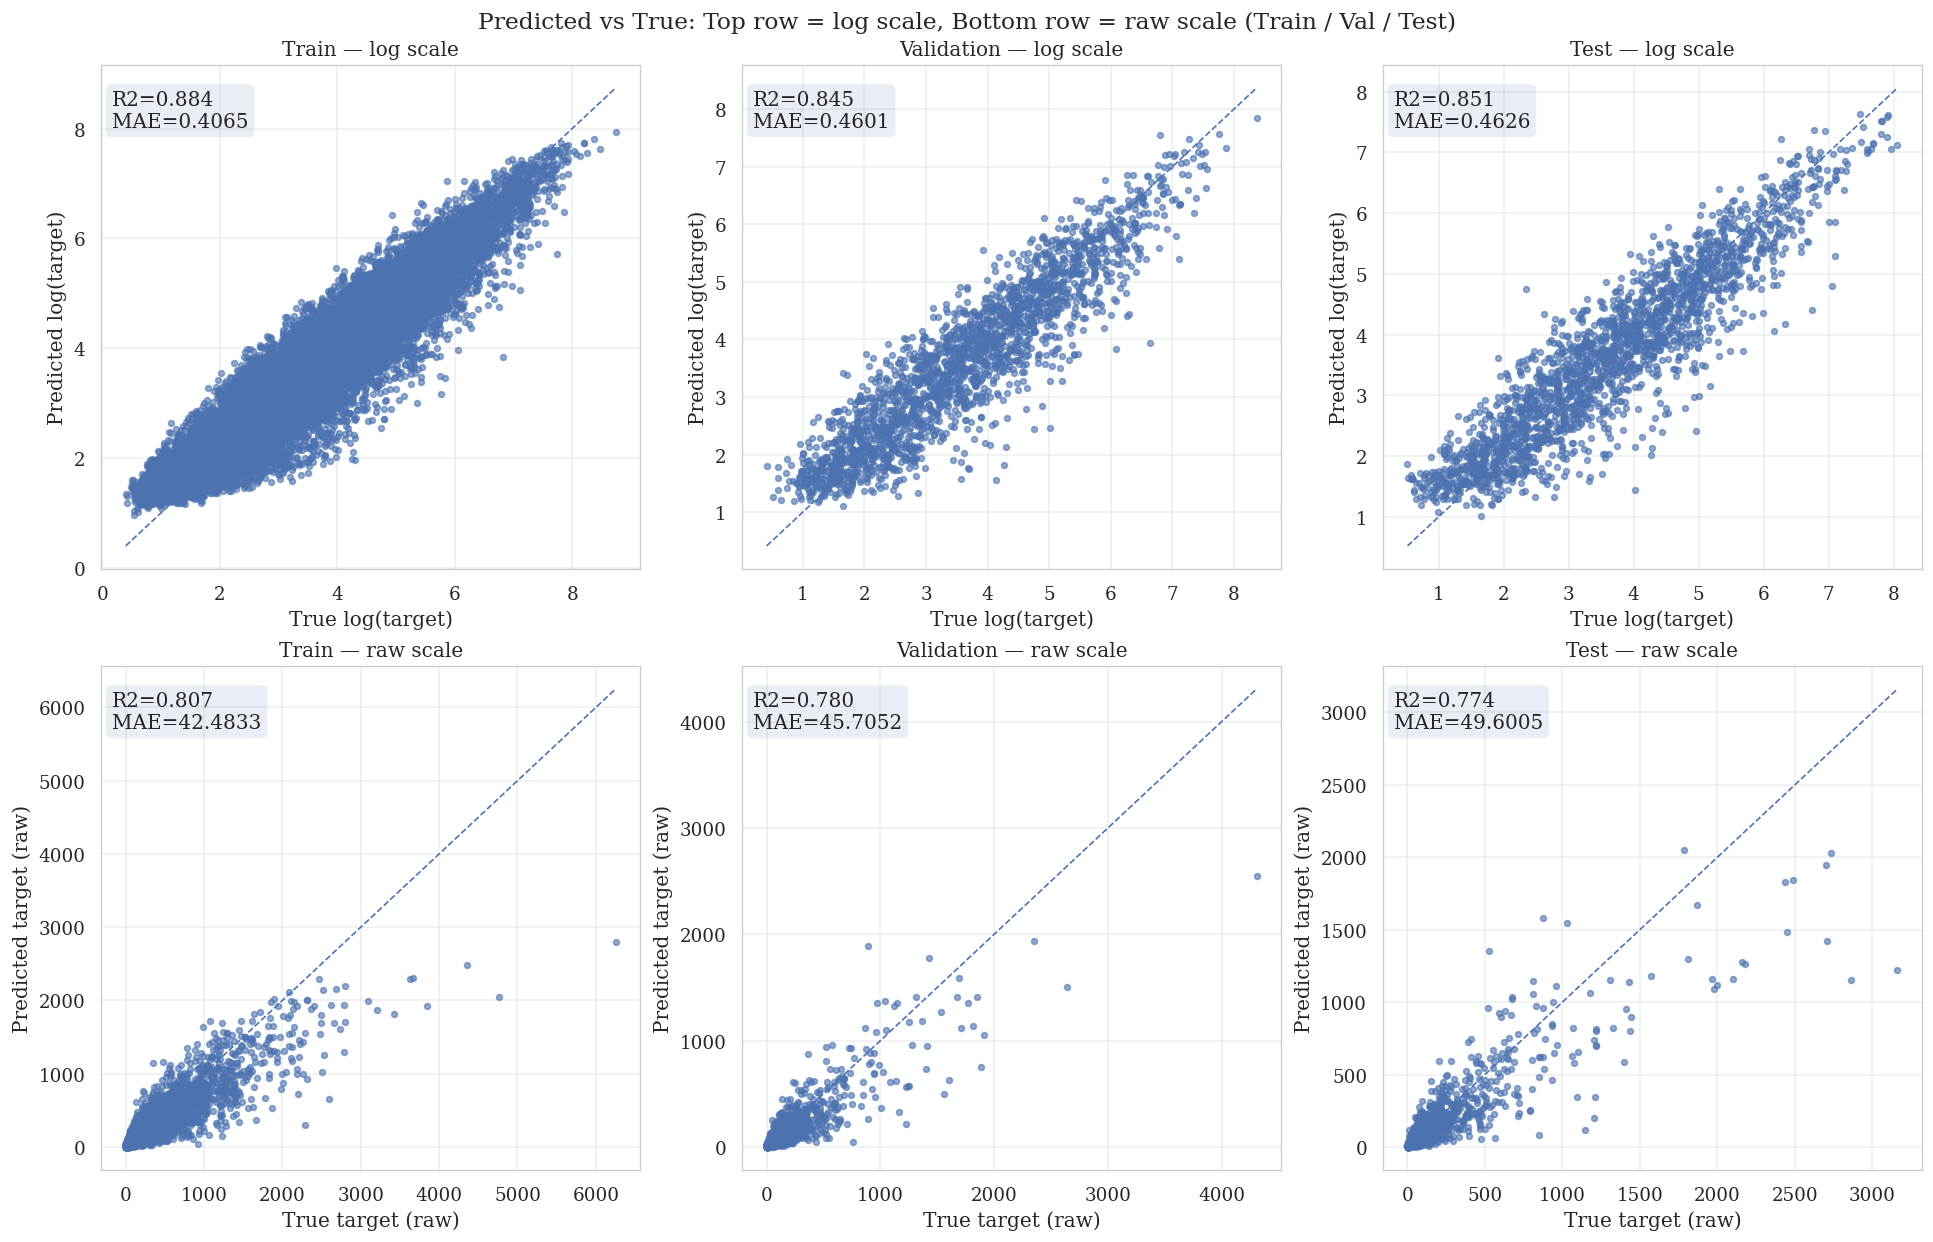

Saved Pred vs True figure -> /content/pred_vs_true_log_and_raw.png


In [9]:
# Cell 7 (REPLACEMENT) — Evaluate, display metrics (log & raw) in tables, and plot Predicted vs True (2 rows × 3 cols)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def compute_metrics(y_true, y_pred):
    """Return dict of R2, MAE, RMSE for given true and predicted arrays."""
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

# --- Predictions (log scale) ---
pred_train_log = final_model.predict(X_train_sel)
pred_val_log   = final_model.predict(X_val_sel)
pred_test_log  = final_model.predict(X_test_sel)

# --- Convert to raw scale ---
pred_train_raw = np.expm1(pred_train_log)
pred_val_raw   = np.expm1(pred_val_log)
pred_test_raw  = np.expm1(pred_test_log)

# --- Compute metrics for log and raw (train/val/test) ---
metrics_log = {
    'Train': compute_metrics(y_train_log.values, pred_train_log),
    'Validation': compute_metrics(y_val_log.values, pred_val_log),
    'Test': compute_metrics(y_test_log.values, pred_test_log)
}

metrics_raw = {
    'Train': compute_metrics(y_train_raw.values, pred_train_raw),
    'Validation': compute_metrics(y_val_raw.values, pred_val_raw),
    'Test': compute_metrics(y_test_raw.values, pred_test_raw)
}

# --- Build formatted DataFrames for display ---
metrics_log_df = pd.DataFrame(metrics_log).T[['R2','MAE','RMSE']]
metrics_raw_df = pd.DataFrame(metrics_raw).T[['R2','MAE','RMSE']]

# Round for neat display
metrics_log_df = metrics_log_df.round({'R2':4, 'MAE':6, 'RMSE':6})
metrics_raw_df = metrics_raw_df.round({'R2':4, 'MAE':6, 'RMSE':6})

# Display side-by-side
display(HTML("<h3>Model performance — Log scale</h3>"))
display(metrics_log_df.style.set_caption("Metrics on log(target)"))

display(HTML("<h3>Model performance — Raw (original) scale</h3>"))
display(metrics_raw_df.style.set_caption("Metrics on raw target"))

# --- Create Predicted vs True plots ---
sets = [
    ('Train', y_train_log.values, pred_train_log, y_train_raw.values, pred_train_raw),
    ('Validation', y_val_log.values, pred_val_log, y_val_raw.values, pred_val_raw),
    ('Test', y_test_log.values, pred_test_log, y_test_raw.values, pred_test_raw)
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10), constrained_layout=True)

for col, (name, y_log_true, y_log_pred, y_raw_true, y_raw_pred) in enumerate(sets):
    # Top row: log
    ax = axes[0, col]
    ax.scatter(y_log_true, y_log_pred, s=12, alpha=0.6)
    # 1:1 line
    mn = min(np.nanmin(y_log_true), np.nanmin(y_log_pred))
    mx = max(np.nanmax(y_log_true), np.nanmax(y_log_pred))
    ax.plot([mn, mx], [mn, mx], linestyle='--', linewidth=1)
    ax.set_title(f"{name} — log scale")
    ax.set_xlabel("True log(target)")
    ax.set_ylabel("Predicted log(target)")
    ax.grid(True, alpha=0.3)

    # Add simple bias/dispersion annotation
    r2 = compute_metrics(y_log_true, y_log_pred)['R2']
    mae = compute_metrics(y_log_true, y_log_pred)['MAE']
    ax.annotate(f"R2={r2:.3f}\nMAE={mae:.4f}", xy=(0.02, 0.95), xycoords='axes fraction',
                ha='left', va='top', bbox=dict(boxstyle='round', alpha=0.12))

    # Bottom row: raw (original) scale
    ax2 = axes[1, col]
    ax2.scatter(y_raw_true, y_raw_pred, s=12, alpha=0.6)
    mn2 = min(np.nanmin(y_raw_true), np.nanmin(y_raw_pred))
    mx2 = max(np.nanmax(y_raw_true), np.nanmax(y_raw_pred))
    ax2.plot([mn2, mx2], [mn2, mx2], linestyle='--', linewidth=1)
    ax2.set_title(f"{name} — raw scale")
    ax2.set_xlabel("True target (raw)")
    ax2.set_ylabel("Predicted target (raw)")
    ax2.grid(True, alpha=0.3)

    r2_raw = compute_metrics(y_raw_true, y_raw_pred)['R2']
    mae_raw = compute_metrics(y_raw_true, y_raw_pred)['MAE']
    ax2.annotate(f"R2={r2_raw:.3f}\nMAE={mae_raw:.4f}", xy=(0.02, 0.95), xycoords='axes fraction',
                 ha='left', va='top', bbox=dict(boxstyle='round', alpha=0.12))

# Overall figure title
fig.suptitle("Predicted vs True: Top row = log scale, Bottom row = raw scale (Train / Val / Test)", fontsize=14, y=1.02)
plt.subplots_adjust(top=0.92)
# Save the figure for later reference
plot_path = "/content/pred_vs_true_log_and_raw.png"
fig.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved Pred vs True figure -> {plot_path}")


Sample fetched:
  station: ANMO
  network: IU
  requested starttime (window): 2022-05-04T12:00:00.000000Z
  sampling_rate: 40.0
  p_index (sample): 1521 p-window samples: 80


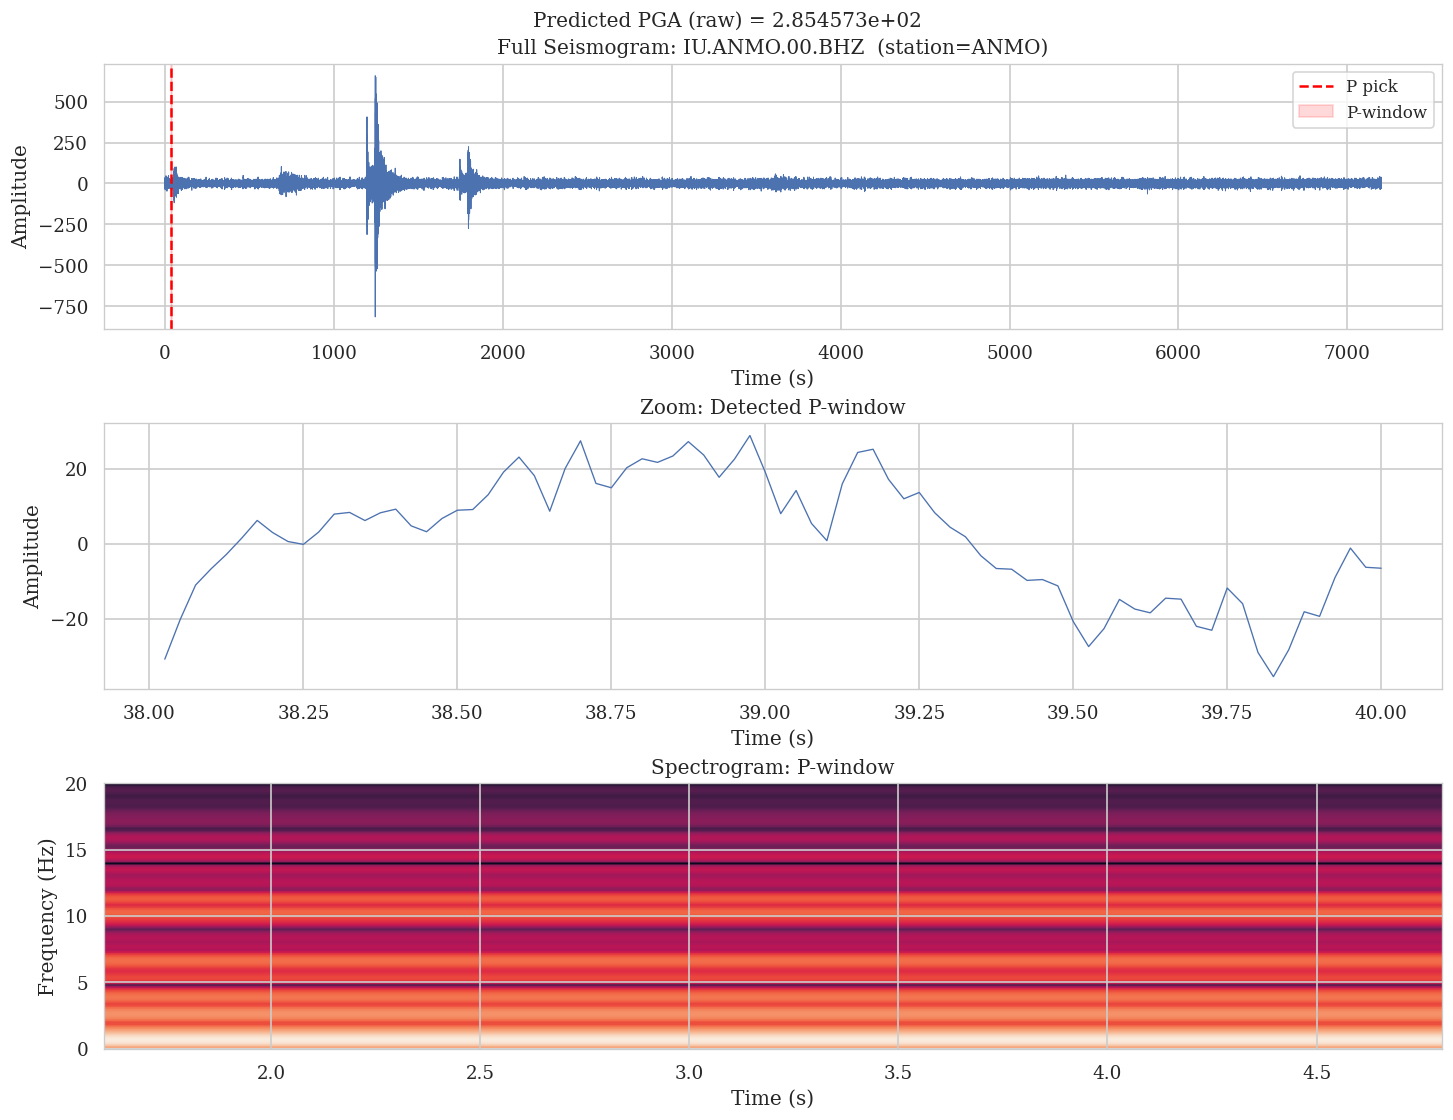

✅ Single-sample prediction saved to /content/single_sample_prediction.csv
✅ Visualization saved to /content/single_sample_prediction.png


,feature,value
0,pkev12,270.406
1,pkev23,14.0372
2,durP,2
3,tauPd,0.0310831
4,tauPt,0.069175
5,PDd,64.3436
6,PVd,470.626
7,PAd,14.0372
8,PDt,28.9122
9,PVt,470.626


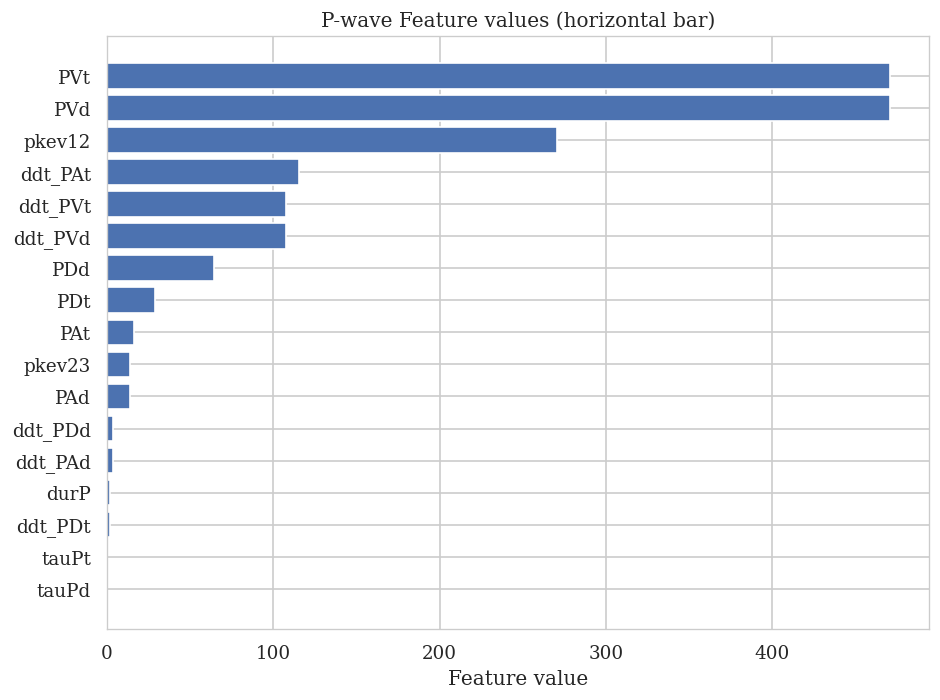

In [10]:
# Cell 8/11 — Fetch ONE random seismogram, extract P-window features, predict, and visualize
client = Client("IRIS")

def p_wave_features_calc(window: np.ndarray, dt: float) -> dict:
    # same function used during training — keep identical
    if len(window) == 0:
        return {k: np.nan for k in p_wave_features}
    durP = len(window) * dt
    PDd = np.max(window) - np.min(window)
    grad = np.gradient(window) / dt
    PVd = np.max(np.abs(grad)) if len(grad) > 0 else 0
    PAd = np.mean(np.abs(window))
    PDt = np.max(window)
    PVt = np.max(grad) if len(grad) > 0 else 0
    PAt = np.sqrt(np.mean(window ** 2))
    tauPd = durP / PDd if PDd != 0 else 0
    tauPt = durP / PDt if PDt != 0 else 0
    ddt = lambda x: np.mean(np.abs(np.gradient(x))) if len(x) > 1 else 0
    ddt_PDd = ddt(window)
    ddt_PVd = ddt(grad)
    ddt_PAd = ddt(np.abs(window))
    ddt_PDt = ddt(np.maximum(window, 0))
    ddt_PVt = ddt(grad)
    ddt_PAt = ddt(window ** 2)
    pkev12 = np.sum(window ** 2) / len(window)
    pkev23 = np.sum(np.abs(window)) / len(window)
    return {
        "pkev12": pkev12, "pkev23": pkev23,
        "durP": durP, "tauPd": tauPd, "tauPt": tauPt,
        "PDd": PDd, "PVd": PVd, "PAd": PAd,
        "PDt": PDt, "PVt": PVt, "PAt": PAt,
        "ddt_PDd": ddt_PDd, "ddt_PVd": ddt_PVd,
        "ddt_PAd": ddt_PAd, "ddt_PDt": ddt_PDt,
        "ddt_PVt": ddt_PVt, "ddt_PAt": ddt_PAt
    }

def fetch_single_seismogram(stations=None, net='IU', year_choices=[2022,2023,2024], max_attempts=8):
    if stations is None:
        stations = ["ANMO","COR","MAJO","KBL"]
    for attempt in range(max_attempts):
        try:
            yr = random.choice(year_choices)
            starttime = UTCDateTime(datetime.datetime(
                yr, random.randint(1,12), random.randint(1,25),
                random.randint(0,21), 0, 0
            ))
            endtime = starttime + 2*3600
            st = None
            for station in stations:
                try:
                    st = client.get_waveforms(net, station, "*", "BHZ", starttime, endtime)
                    if st and len(st) > 0:
                        break
                except Exception:
                    continue
            if st is None or len(st) == 0:
                continue
            tr = st[0].copy()
            tr.detrend("demean")
            tr.filter("bandpass", freqmin=0.5, freqmax=20.0)
            dt = tr.stats.delta
            cft = classic_sta_lta(tr.data, int(1/dt), int(10/dt))
            trig = trigger_onset(cft, 2.5, 1.0)
            if len(trig) == 0:
                continue
            p_index = int(trig[0][0])
            win = int(2.0 / dt)
            p_window = tr.data[p_index : p_index + win]
            if len(p_window) < 10:
                continue
            feats = p_wave_features_calc(p_window, dt)
            meta = {
                "station": tr.stats.station,
                "network": tr.stats.network,
                "starttime": str(starttime),
                "sampling_rate": tr.stats.sampling_rate,
                "p_index": p_index,
                "win_samples": len(p_window)
            }
            return {"trace": tr, "p_window": p_window, "p_index": p_index, "feats": feats, "meta": meta}
        except Exception:
            continue
    return None

# Fetch, predict, and visualize
sample = fetch_single_seismogram()
if sample is None:
    print("⚠️ Failed to fetch a valid seismogram sample. Try increasing max_attempts or change station list.")
else:
    tr = sample['trace']
    p_window = sample['p_window']
    p_index = sample['p_index']
    feats = sample['feats']
    meta = sample['meta']

    print("Sample fetched:")
    print("  station:", meta['station'])
    print("  network:", meta['network'])
    print("  requested starttime (window):", meta['starttime'])
    print("  sampling_rate:", meta['sampling_rate'])
    print("  p_index (sample):", meta['p_index'], "p-window samples:", meta['win_samples'])

    # Predict
    feats_df = pd.DataFrame([feats])
    sample_X = np.log1p(feats_df[p_wave_features].astype(float))
    sample_X_sel = selector.transform(imputer.transform(scaler.transform(sample_X)))
    pred_log = final_model.predict(sample_X_sel)[0]
    pred_pga = float(np.expm1(pred_log))

    # Save CSV row
    out = {**meta, **feats, 'pred_pga': pred_pga}
    pd.DataFrame([out]).to_csv('/content/single_sample_prediction.csv', index=False)

    # Visualize: full seismogram, P-window zoom, spectrogram
    t = np.arange(0, tr.stats.npts) * tr.stats.delta
    p_time = p_index * tr.stats.delta
    win_t = np.arange(0, len(p_window)) * tr.stats.delta + p_time

    fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

    # Full seismogram
    ax[0].plot(t, tr.data, linewidth=0.6)
    ax[0].axvline(p_time, color='red', linestyle='--', label='P pick')
    ax[0].axvspan(p_time, p_time + len(p_window)*tr.stats.delta, alpha=0.15, color='red', label='P-window')
    ax[0].set_title(f"Full Seismogram: {tr.id}  (station={meta['station']})")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper right', fontsize='small')

    # Zoom (P-window)
    ax[1].plot(win_t, p_window, linewidth=0.8)
    ax[1].set_title("Zoom: Detected P-window")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Amplitude')

    # Spectrogram
    try:
        ax[2].specgram(p_window, NFFT=256, Fs=meta['sampling_rate'], noverlap=128)
        ax[2].set_title("Spectrogram: P-window")
        ax[2].set_xlabel('Time (s)')
        ax[2].set_ylabel('Frequency (Hz)')
    except Exception:
        freqs = np.fft.rfftfreq(len(p_window), d=1.0/meta['sampling_rate'])
        psd = np.abs(np.fft.rfft(p_window))**2
        ax[2].semilogy(freqs, psd)
        ax[2].set_title("FFT power (P-window)")
        ax[2].set_xlabel('Frequency (Hz)')
        ax[2].set_ylabel('Power')

    fig.suptitle(f"Predicted PGA (raw) = {pred_pga:.6e}", fontsize=12, y=1.02)
    figfile = '/content/single_sample_prediction.png'
    fig.savefig(figfile, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Single-sample prediction saved to /content/single_sample_prediction.csv")
    print(f"✅ Visualization saved to {figfile}")

    # Display features in a neat table + bar chart
    display(HTML("<h4>Extracted P-wave features (used for prediction)</h4>"))
    feat_table = feats_df.T.rename(columns={0:'value'}).reset_index().rename(columns={'index':'feature'})
    display(feat_table.style.format({'value':'{:.6g}'}))

    # Bar chart
    sorted_f = feat_table.assign(absval=feat_table['value'].abs()).sort_values('absval', ascending=True)
    plt.figure(figsize=(8,6))
    plt.barh(sorted_f['feature'], sorted_f['value'])
    plt.xlabel('Feature value')
    plt.title('P-wave Feature values (horizontal bar)')
    plt.tight_layout()
    plt.show()


In [11]:
# Cell 11/11 — Persist artifacts & print final summary
artifacts_dir = "/content/eew_artifacts"
os.makedirs(artifacts_dir, exist_ok=True)
joblib.dump(final_model, os.path.join(artifacts_dir, "xgb_eew_final.joblib"))
joblib.dump({'scaler': scaler, 'imputer': imputer, 'selector': selector, 'p_wave_features': p_wave_features}, os.path.join(artifacts_dir, "preproc_objects.joblib"))

# copy last CSV and figure into artifacts
if os.path.exists('/content/single_sample_prediction.csv'):
    os.replace('/content/single_sample_prediction.csv', os.path.join(artifacts_dir, "single_sample_prediction.csv"))
if os.path.exists('/content/single_sample_prediction.png'):
    os.replace('/content/single_sample_prediction.png', os.path.join(artifacts_dir, "single_sample_prediction.png"))

print("✅ All artifacts saved to:", artifacts_dir)
print("Notebook complete — the pipeline trained a final XGB (use your best_params), produced a single-sample prediction, visualizations, and a trigger analysis table.")


✅ All artifacts saved to: /content/eew_artifacts
Notebook complete — the pipeline trained a final XGB (use your best_params), produced a single-sample prediction, visualizations, and a trigger analysis table.


In [12]:
!pip install --quiet pyngrok

In [14]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib
from obspy import UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import pydeck as pdk
import warnings, traceback, time

warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="Selected high corner frequency")

# ---- Load model & preprocessing ----
try:
    model = joblib.load("xgb_eew_final.joblib")
    preproc = joblib.load("preproc_objects.joblib")
    scaler = preproc["scaler"]
    imputer = preproc["imputer"]
    selector = preproc["selector"]
    p_wave_features = preproc["p_wave_features"]
except Exception as e:
    st.error(f"❌ Could not load model/preprocessing: {e}")
    st.stop()

client = None

# ---- Page Config & Style ----
st.set_page_config(page_title="EEW PGA Dashboard", layout="wide", page_icon="🌍")
st.markdown("""
<style>
/* Dark mode background */
body, .stApp {
    background-color: #121212;
    color: #ffffff;
}
/* Header */
.big-title { font-size: 32px; font-weight:700; margin-bottom:4px; color:#fff; }
.subheader { color:#ccc; font-size:15px; margin-bottom:10px; }
/* Divider */
.divider { border-bottom: 1px solid rgba(255,255,255,0.06); margin: 12px 0px; }
/* Badge / metric */
.badge { display:inline-block; padding:6px 12px; border-radius:18px; font-size:13px; font-weight:600; color:white; margin-top:6px; }
/* Group card */
.group-card { border-radius:10px; padding:12px; margin:6px 0px; color:#ffffff !important; box-shadow: 0 6px 20px rgba(2,6,23,0.18); border: 1px solid rgba(0,0,0,0.08); background: linear-gradient(120deg,#2ecc71,#3498db); }
.group-title { font-weight:700; font-size:14px; margin-bottom:6px; color:#ffffff !important; }
.feature-row { display:flex; justify-content:space-between; align-items:center; padding:4px 0px; font-size:13px; }
.feature-name { color:#ffffff !important; font-weight:600; }
.feature-val { font-weight:800; color:#ffffff !important; margin-left:8px; font-size:14px; }
.small-muted { color:#cfcfcf; font-size:13px; }

/* Reduce gap above gauge placeholder to pull it up slightly */
.gauge-container { margin-top: -8px; }
</style>
""", unsafe_allow_html=True)

# ---- Header ----
st.markdown('<div class="big-title">🌍 Earthquake Early Warning — PGA Predictor</div>', unsafe_allow_html=True)
st.markdown('<div class="subheader">Fetch seismograms from IRIS, extract P-wave features, and predict Peak Ground Acceleration (PGA) using a trained XGBoost model.</div>', unsafe_allow_html=True)
st.markdown('<div class="divider"></div>', unsafe_allow_html=True)

# ---- Sidebar Inputs ----
st.sidebar.header("📡 Station Parameters")
network = st.sidebar.text_input("Network", "IU")
station = st.sidebar.text_input("Station Code", "ANMO")
date_selected = st.sidebar.date_input("Date", pd.to_datetime("2024-10-01"))
hour = st.sidebar.number_input("Hour (UTC)", 0, 23, 0)
st.sidebar.markdown("---")
year, month, day = date_selected.year, date_selected.month, date_selected.day

# ---- Historical examples ----
historical_examples = [
    {"name":"2011 Great Tōhoku", "year":2011, "pga_g":2.75},
    {"name":"1994 Northridge", "year":1994, "pga_g":1.82},
    {"name":"1999 Chi-Chi (TW)", "year":1999, "pga_g":1.00},
    {"name":"1995 Kobe", "year":1995, "pga_g":0.91},
    {"name":"2010 El Mayor–Cucapah","year":2010,"pga_g":0.58},
    {"name":"2008 Wenchuan", "year":2008, "pga_g":0.40},
    {"name":"2004 Sumatra-Andaman","year":2004,"pga_g":0.50},
    {"name":"2004 Parkfield","year":2004,"pga_g":0.05},
    {"name":"Example moderate event","year":2004,"pga_g":0.20},
    {"name":"Local light quake","year":2019,"pga_g":0.008},
]

# ---- Group definitions ----
groups = {
    "Time-based": {"keys":["durP","tauPd","tauPt"]},
    "Amplitude-based": {"keys":["PDd","PVd","PAd","PDt","PVt","PAt"]},
    "Derivative-based": {"keys":["ddt_PDd","ddt_PVd","ddt_PAd","ddt_PDt","ddt_PVt","ddt_PAt"]},
    "Energy-based": {"keys":["pkev12","pkev23"]}
}
group_colors = {
    "Time-based":"#2b8cff",
    "Amplitude-based":"#ff8c42",
    "Derivative-based":"#2ecc71",
    "Energy-based":"#9b59b6"
}

# ---- Helper functions ----
def round_to_bin(val, bin_size=0.05): return round(val / bin_size) * bin_size
def find_examples_near_bin(rounded_bin, tol=0.05): return [ev for ev in historical_examples if abs(ev["pga_g"] - rounded_bin) <= tol]
def pga_intensity_level(pga_g):
    if pga_g < 0.001: return ("Micro / No Shake", "#00b050")
    if pga_g < 0.2: return ("Light", "#ffc000")
    if pga_g < 0.25: return ("Moderate", "#ff8000")
    if pga_g < 0.3: return ("Strong", "#ff3333")
    if pga_g < 0.4: return ("Severe", "#8000ff")
    return ("Extreme", "#6600cc")

def p_wave_features_calc(window, dt):
    durP=len(window)*dt
    PDd = np.max(window)-np.min(window) if len(window)>0 else 0.0
    grad = np.gradient(window)/dt if len(window)>1 else np.array([0.0])
    PVd = np.max(np.abs(grad)) if len(grad)>0 else 0.0
    PAd = np.mean(np.abs(window)) if len(window)>0 else 0.0
    PDt = np.max(window) if len(window)>0 else 0.0
    PVt = np.max(grad) if len(grad)>0 else 0.0
    PAt = np.sqrt(np.mean(window**2)) if len(window)>0 else 0.0
    tauPd = durP/PDd if PDd!=0 else 0.0
    tauPt = durP/PDt if PDt!=0 else 0.0
    ddt = lambda x: np.mean(np.abs(np.gradient(x))) if len(x)>1 else 0.0
    return {
        "pkev12": np.sum(window**2)/len(window) if len(window)>0 else 0.0,
        "pkev23": np.sum(np.abs(window))/len(window) if len(window)>0 else 0.0,
        "durP": durP, "tauPd": tauPd, "tauPt": tauPt,
        "PDd": PDd, "PVd": PVd, "PAd": PAd, "PDt": PDt, "PVt": PVt, "PAt": PAt,
        "ddt_PDd": ddt(window), "ddt_PVd": ddt(grad), "ddt_PAd": ddt(np.abs(window)),
        "ddt_PDt": ddt(np.maximum(window,0)), "ddt_PVt": ddt(grad), "ddt_PAt": ddt(window**2)
    }

def draw_gauge(ax, value_norm, color="#FF8000"):
    theta=np.linspace(-np.pi/2,np.pi/2,200)
    ax.plot(np.cos(theta),np.sin(theta),linewidth=6,color="#333")
    ax.plot(np.cos(theta),np.sin(theta),linewidth=4,color=color,alpha=0.9)
    for v in np.linspace(0,1,5):
        ang=(-90+v*180)*np.pi/180
        x0,y0=0.92*np.cos(ang),0.92*np.sin(ang)
        x1,y1=1.05*np.cos(ang),1.05*np.sin(ang)
        ax.plot([x0,x1],[y0,y1],color="#666",lw=1)
    angle=-90+value_norm*180
    ang_rad=angle*np.pi/180
    ax.plot([0,0.85*np.cos(ang_rad)],[0,0.85*np.sin(ang_rad)],color="#222",lw=3)
    ax.add_patch(plt.Circle((0,0),0.05,color="#222"))
    ax.set_xlim(-1.2,1.2); ax.set_ylim(-0.2,1.2); ax.axis("off")

def detect_spikes_simple(data, dt, min_distance_s=0.5, threshold_factor=3.0, max_peaks=8):
    absd=np.abs(data)
    meanv=np.mean(absd)
    stdv=np.std(absd)
    thresh=meanv+threshold_factor*stdv
    if np.isnan(thresh) or thresh<=0: return []
    dist=max(1,int(round(min_distance_s/dt)))
    peaks=[]
    i=1; N=len(absd)
    while i<N-1:
        if absd[i]>thresh and absd[i]>absd[i-1] and absd[i]>=absd[i+1]:
            if len(peaks)==0 or (i-peaks[-1][0])>=dist:
                peaks.append((i,float(absd[i])))
                i+=dist
                continue
        i+=1
    peaks=sorted(peaks,key=lambda x:x[1],reverse=True)[:max_peaks]
    return peaks

def classify_delay(delta_s):
    if delta_s<=0: return "At/Before P"
    if delta_s<60: return "Likely S (local/regional)"
    if delta_s<600: return "Regional / long-period S"
    return "Teleseismic / separate event"

def hex_to_rgb(h):
    h = h.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]

# ---- Main workflow ----
if st.sidebar.button("🚀 Fetch & Predict"):
    try:
        st.toast("Initializing IRIS client...", icon="🔄")
        from obspy.clients.fdsn import Client
        if client is None: client = Client("IRIS")

        st.toast("Fetching waveform...", icon="🌐")
        start = UTCDateTime(f"{year}-{month:02d}-{day:02d}T{hour:02d}:00:00")
        end = start + 2*3600
        stn = client.get_waveforms(network, station, "*", "BHZ", start, end)[0]

        st.toast("Preprocessing waveform...", icon="⚙️")
        stn.detrend("demean")
        stn.filter("bandpass", freqmin=0.5, freqmax=19.9)
        dt = stn.stats.delta

        # ---- Get station coordinates (robust) ----
        lat = None; lon = None
        try:
            inventory = client.get_stations(network=network, station=station, level="station")
            # robust extraction
            if hasattr(inventory, "networks") and len(inventory.networks) > 0:
                net = inventory.networks[0]
                if hasattr(net, "stations") and len(net.stations) > 0:
                    sta = net.stations[0]
                    lat = getattr(sta, "latitude", None)
                    lon = getattr(sta, "longitude", None)
            # fallback older indexing
            if lat is None or lon is None:
                try:
                    lat = inventory[0][0].latitude
                    lon = inventory[0][0].longitude
                except Exception:
                    pass
        except Exception as e:
            # don't fail the whole app for map issues
            st.sidebar.warning(f"Could not fetch station metadata: {e}")

        cft = classic_sta_lta(stn.data, max(1,int(round(1.0/dt))), max(1,int(round(10.0/dt))))
        trig = trigger_onset(cft,2.5,1.0)
        if len(trig)==0:
            st.warning("⚠️ No P-wave detected.")
        else:
            p_index = int(trig[0][0])
            win = max(1,int(round(2.0/dt)))
            p_window = stn.data[p_index:p_index+win]
            feats = p_wave_features_calc(p_window,dt)

            st.toast("Predicting PGA...", icon="🧠")
            X = np.log1p(pd.DataFrame([feats])[p_wave_features])
            X_sel = selector.transform(imputer.transform(scaler.transform(X)))
            pred_log = model.predict(X_sel)[0]
            pred_pga = np.expm1(pred_log)
            pred_g = pred_pga / 980.0
            rounded_bin = round_to_bin(pred_g,0.05)
            examples = find_examples_near_bin(rounded_bin,0.05)
            level_label, level_color = pga_intensity_level(pred_g)

            # Tabs: add a Map tab in the main dashboard
            overview, waveforms, features_tab, map_tab = st.tabs(["📊 Overview","📈 Waveforms","🧮 P-Wave Features","📍 Station Map"])

            # ---- Overview ----
            with overview:
                st.subheader("Predicted PGA Results")
                c1,c2=st.columns([2,1])
                with c1:
                    st.metric("Predicted PGA (cm/s²)",f"{pred_pga:.3f}")
                    st.metric("Predicted PGA (g)",f"{pred_g:.5f}")
                    st.markdown(f'<div class="badge" style="background-color:{level_color}">{level_label}</div>',unsafe_allow_html=True)
                with c2:
                    # put gauge in container with reduced top margin (CSS class)
                    placeholder=st.empty()
                    placeholder.markdown('<div class="gauge-container"></div>', unsafe_allow_html=True)
                    cap=0.25
                    value_norm=min(pred_g/cap,1.0)
                    steps=16
                    # animate needle quickly
                    for i in range(1,steps+1):
                        interp=(i/steps)*value_norm
                        figg,axg=plt.subplots(figsize=(3.2,2.4))
                        if interp<0.05: color="#00b050"
                        elif interp<0.2: color="#ffc000"
                        elif interp<0.4: color="#ff8000"
                        elif interp<0.6: color="#ff3333"
                        else: color="#8000ff"
                        draw_gauge(axg,interp,color=color)
                        # pull title up a bit using pad
                        axg.set_title("PGA Intensity", fontsize=10, pad=-8)
                        placeholder.pyplot(figg)
                        plt.close(figg)
                        time.sleep(0.008)
                    figg_fin,axg_fin=plt.subplots(figsize=(3.2,2.4))
                    draw_gauge(axg_fin,value_norm,color=level_color)
                    axg_fin.set_title("PGA Intensity", fontsize=10, pad=-8)
                    placeholder.pyplot(figg_fin)
                    plt.close(figg_fin)

            # ---- Waveforms ----
            with waveforms:
                st.subheader("Waveform Visualization")
                data = stn.data
                spikes = detect_spikes_simple(data,dt)
                spike_idx = None
                for idx,h in sorted(spikes,key=lambda x:x[0]):
                    if idx*dt > p_index*dt + 1.0:
                        spike_idx = idx
                        break
                col1,col2,col3 = st.columns(3)

                # col1: Spike Zoom (leftmost)
                with col1:
                    st.markdown("**Spike zoom**")
                    if spike_idx is None: st.info("No significant later spike detected.")
                    else:
                        spike_half=20.0
                        z_start_s=max(0.0,spike_idx*dt-spike_half)
                        z_end_s=min(len(data)*dt,spike_idx*dt+spike_half)
                        zs=int(z_start_s/dt)
                        ze=int(z_end_s/dt)
                        t_z_rel=(np.arange(zs,ze)*dt)-(spike_idx*dt)
                        fig_c,ax_c=plt.subplots(figsize=(5,3))
                        ax_c.plot(t_z_rel,data[zs:ze],lw=0.6,color="#1f77b4")
                        ax_c.axvline(0.0,color="r",ls="--")
                        p_rel=p_index*dt-(spike_idx*dt)
                        if z_start_s<=p_index*dt<=z_end_s:
                            ax_c.axvline(p_rel,color="orange",ls=":",alpha=0.7)
                        ax_c.set_xlabel("Seconds relative to spike")
                        ax_c.set_ylabel("Amplitude")
                        st.pyplot(fig_c)
                        plt.close(fig_c)

                # col2: Pre-P baseline (middle)
                with col2:
                    st.markdown("**Pre-P baseline**")
                    pre_sec=5.0; post_sec=2.0
                    p_time_s=p_index*dt
                    s_time=max(0.0,p_time_s-pre_sec)
                    e_time=min(len(data)*dt,p_time_s+post_sec)
                    s_idx=int(s_time/dt)
                    e_idx=int(e_time/dt)
                    t_rel=(np.arange(s_idx,e_idx)*dt)-p_time_s
                    fig_a,ax_a=plt.subplots(figsize=(5,3))
                    ax_a.plot(t_rel,data[s_idx:e_idx],lw=0.6,color="#1f77b4")
                    ax_a.axvline(0.0,color="r",ls="--")
                    ax_a.set_xlabel("Seconds relative to P pick")
                    ax_a.set_ylabel("Amplitude")
                    st.pyplot(fig_a)
                    plt.close(fig_a)

                # col3: Detected P-window (rightmost)
                with col3:
                    st.markdown("**Detected P-Window**")
                    t_pw=np.arange(len(p_window))*dt
                    fig_b,ax_b=plt.subplots(figsize=(5,3))
                    ax_b.plot(t_pw,p_window,lw=0.8,color="#2ca02c")
                    ax_b.set_xlabel("Seconds from P pick")
                    ax_b.set_ylabel("Amplitude")
                    ax_b.text(0.02,0.9,f"dur={feats['durP']:.3g}s PAt={feats['PAt']:.3g}", transform=ax_b.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.8))
                    st.pyplot(fig_b)
                    plt.close(fig_b)

            # ---- Features tab ----
            with features_tab:
                st.subheader("P-Wave Features")
                try:
                    feats_df=pd.DataFrame.from_dict(feats,orient="index",columns=["Value"])
                    feats_df.index.name="Feature"
                except Exception:
                    feats_df=pd.DataFrame(columns=["Value"])
                group_names=list(groups.keys())
                cols=st.columns(len(group_names),gap="small")
                for i,gname in enumerate(group_names):
                    with cols[i]:
                        bg=group_colors.get(gname,"#2b8cff")
                        st.markdown(f"<div class='group-card' style='background:{bg};'>",unsafe_allow_html=True)
                        st.markdown(f"<div class='group-title'>{gname}</div>",unsafe_allow_html=True)
                        keys=[k for k in groups[gname]["keys"] if k in feats_df.index]
                        if not keys: st.markdown("<div style='color:#ffffff'>_No features_</div>",unsafe_allow_html=True)
                        else:
                            for k in keys:
                                v=float(feats_df.loc[k,"Value"])
                                st.markdown(f"<div class='feature-row'><div class='feature-name'>{k}</div><div class='feature-val'>{v:.5g}</div></div>",unsafe_allow_html=True)
                        st.markdown("</div>",unsafe_allow_html=True)

            # ---- Station Map tab (main dashboard) ----
            with map_tab:
                st.subheader("Station Location & PGA Intensity")
                if lat is None or lon is None:
                    st.warning("Station coordinates unavailable — cannot render map.")
                else:
                    # prepare a marker whose color/intensity is based on pred_g
                    color_rgb = hex_to_rgb(level_color)
                    # radius: scale with pred_g (clamped)
                    radius_m = max(5000, min(100000, int(20000 * (pred_g / 0.25) + 5000))) if pred_g>0 else 5000
                    map_df = pd.DataFrame([{"lat": lat, "lon": lon, "pga_g": pred_g, "name": station}])
                    # center view
                    view_state = pdk.ViewState(latitude=lat, longitude=lon, zoom=5, pitch=0)
                    layer = pdk.Layer(
                        "ScatterplotLayer",
                        data=map_df,
                        get_position='[lon, lat]',
                        get_radius=radius_m,
                        radius_scale=1,
                        get_fill_color=color_rgb + [200],  # add alpha
                        pickable=True,
                        auto_highlight=True
                    )
                    tooltip = {"html": "<b>Station:</b> {name} <br/> <b>Pred PGA (g):</b> {pga_g}", "style": {"color": "white"}}
                    deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
                    st.pydeck_chart(deck)

    except Exception as e:
        st.error(f"❌ Runtime error: {e}")
        st.text(traceback.format_exc())
        st.info("App recovered — adjust parameters and retry.")


Overwriting app.py


In [24]:
%%bash
# kill old instances safely
pkill -f streamlit || true

# start streamlit in the background and log to streamlit.log
nohup streamlit run app.py \
  --server.headless true \
  --server.address 0.0.0.0 \
  --server.port 8501 \
  --server.enableCORS false \
  --server.enableXsrfProtection false \
  > streamlit.log 2>&1 &

# small wait then show the log so you can see server start and any startup errors
sleep 2
tail -n 200 streamlit.log


In [25]:
# Colab cell (python)
from pyngrok import ngrok
# Kill any running ngrok tunnels from this session
ngrok.kill()

# Set the authorized token directly in the code (less secure than using secrets)
# Replace 'YOUR_AUTHORIZED_TOKEN_HERE' with the token you provided.
# This is a workaround for demonstration based on your request.
# For production, use Colab secrets as recommended.
ngrok.set_auth_token("") #replace with your ngrok token to run the streamlit app

public_url = ngrok.connect(8501, "http")
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://stoically-sedimentologic-ashley.ngrok-free.dev" -> "http://localhost:8501"
